<a href="https://colab.research.google.com/github/spdsp04/Eye_for_Blind/blob/main/Eye_for_Blind_Durgesh_Chaubey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [ ]:
#Import all the required libraries

import os
import numpy as np
import cv2
import PIL
from PIL import Image
import glob
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
from function import *
import gtts
from gtts import gTTS
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# version of Libs
print('tensorflow: ', tf.__version__)
print('sklearn: ', sklearn.__version__)
print('gtts: ', gtts.__version__) # need :sudo apt-get install mpg321
print('pandas: ', pd.__version__)
print('pillow: ', PIL.__version__)

tensorflow:  2.7.0
sklearn:  0.23.2
gtts:  2.3.2
pandas:  1.4.3
pillow:  9.2.0


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
#Import the dataset and read the image into a seperate variable
#Count all of Images in folder data/Images
data_dir='../data'
all_imgs = glob.glob(data_dir + '/Images/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


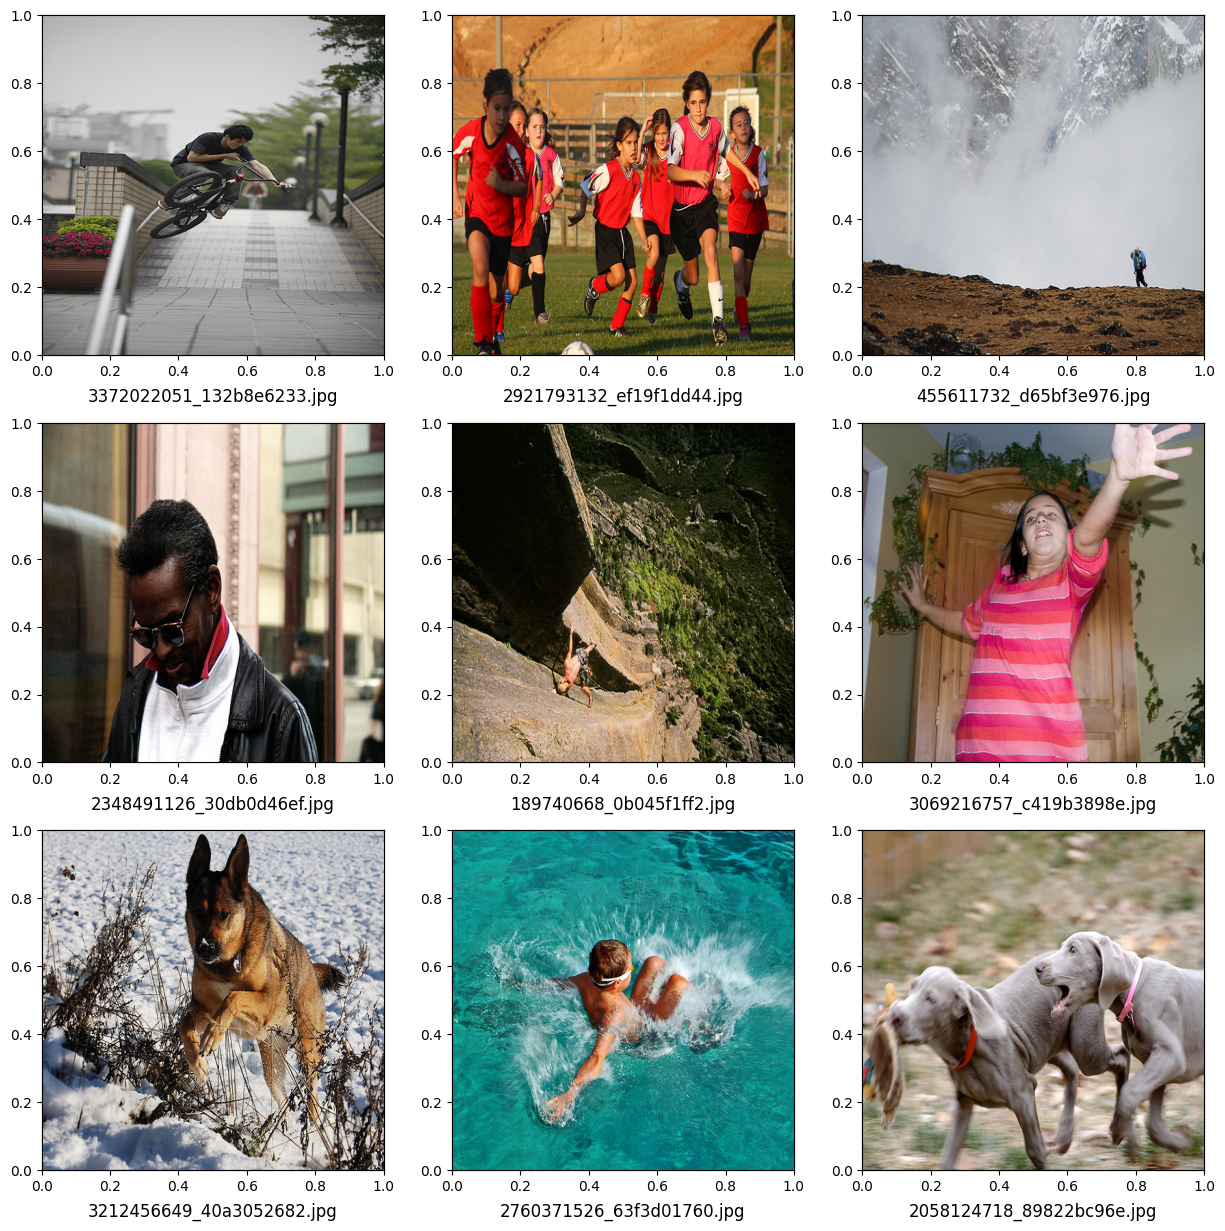

In [ ]:
#Visualise both the images in the dataset
show_img(3,3, all_imgs)

In [ ]:
#Read Captions in file captions.txt and Convert to Dataframe
def load_doc():
    df_cap = pd.read_csv(data_dir+'/captions.txt', sep = ',')
    return df_cap

df_cap = load_doc()
df_cap.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
df_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [ ]:
# Create new Column with full Path of images
images_path = os.path.abspath(data_dir)+'/Images'
all_img_vector = [images_path+'/'+df_cap['image'][i] for i in range(len(df_cap))]
all_img_vector[:5]

['/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg',
 '/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg',
 '/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg',
 '/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg',
 '/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg']

In [ ]:
df_cap['Path'] = all_img_vector
df_cap.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                                Path  
0  /home/xavier/Documents/LJMU/Eye_for_blind_Root...  
1  /home/xavier/Documents/LJMU/Eye_for_blind_Root...  
2  /home/xavier/Documents/LJMU/Eye_for_blind_Root...  
3  /home/xavier/Documents/LJMU/Eye_for_blind_Root...  
4  /home/xavier/Documents/LJMU/Eye_for_blind_Root...

In [ ]:
#Modify Columns name
df_cap = df_cap[['image', 'Path', 'caption']]
df_cap = df_cap.rename(columns={'image': 'ID', 'caption': 'Captions'})

df_cap.head()

ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                Path  \
0  /home/xavier/Documents/LJMU/Eye_for_blind_Root...   
1  /home/xavier/Documents/LJMU/Eye_for_blind_Root...   
2  /home/xavier/Documents/LJMU/Eye_for_blind_Root...   
3  /home/xavier/Documents/LJMU/Eye_for_blind_Root...   
4  /home/xavier/Documents/LJMU/Eye_for_blind_Root...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
#Create a list which contains all the captions
#Mark sentences with <start> and <end> identification during training
df_cap['Captions'] = df_cap['Captions'].apply(lambda x: standardize(x))
df_cap['Captions'][:5]

2023-05-24 22:38:50.610855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 22:38:50.614887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 22:38:50.615355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 22:38:50.616433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

0    <start> a child in a pink dress is climbing up...
1    <start> a girl going into a wooden building  <...
2    <start> a little girl climbing into a wooden p...
3    <start> a little girl climbing the stairs to h...
4    <start> a little girl in a pink dress going in...
Name: Captions, dtype: object

In [ ]:
# Count total of Captions. Each image has 5 caps attached.
print("Total captions present in the dataset: "+ str(len(df_cap['Captions'])))
print("Total images present in the dataset: " + str(len(df_cap['Path'])))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
#Create the vocabulary & the counter for the captions
vocabulary=[word.lower() for line in df_cap['Captions'] for word in line.split()]
val_count=Counter(vocabulary)
val_count.most_common(32)

[('a', 62986),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

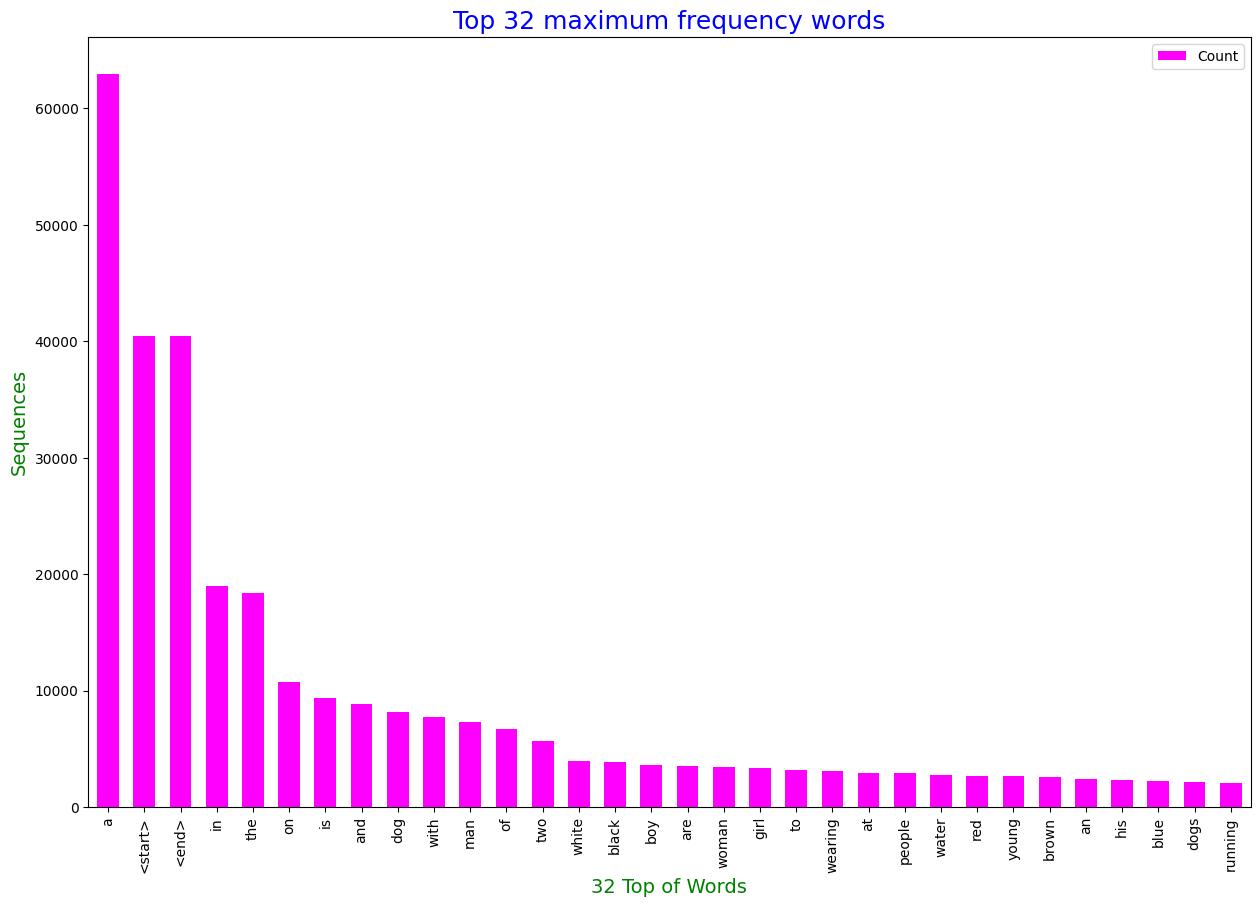

In [ ]:
#Visualise the top 32 occuring words in the captions include <start> and <end>

most_top_word(val_count, ntop=32)

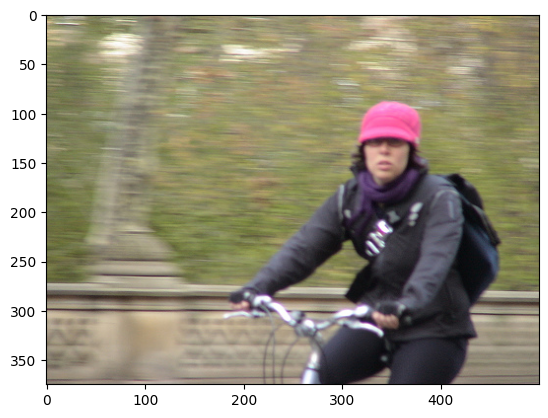

<start> a woman in a pink hat and a navy blue coat riding a bicycle  <end>
<start> a woman wearing a pink cap riding a bicycle <end>
<start> a woman wearing black clothes  a purple scarf  and a pink hat is riding a bike  <end>
<start> a woman with glasses and a pink hat rides her bike  <end>
<start> the woman is wearing a pink hat and is riding a bike in the park  <end>


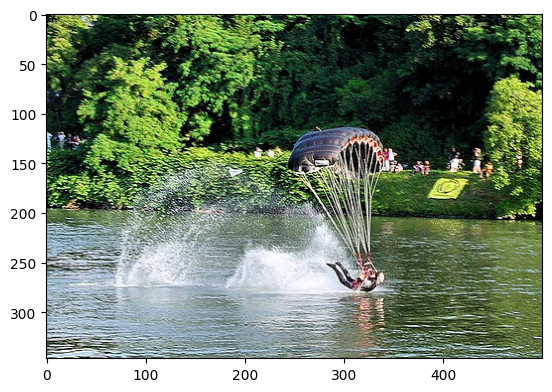

<start> a man crashes into the water with his parachute  <end>
<start> a parasailer splashes along the surface of a lake  <end>
<start> a person hanging from a parachute makes a splash as their body hits the water  <end>
<start> a person in a parachute sliding across the water  <end>
<start> the parasailer is skipping across the water  <end>


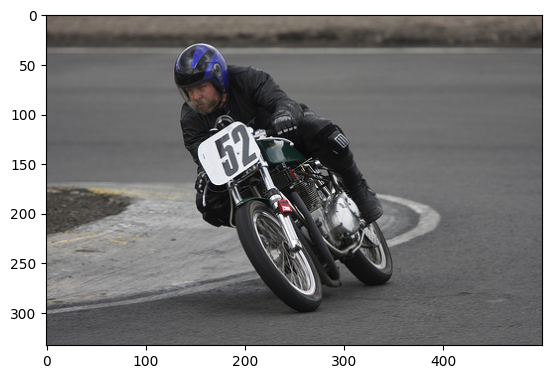

<start> a man on a motorcycle going around a corner  <end>
<start> a man rides a green motorcycle around a corner <end>
<start> a man with a blue helmet leans into a sharp turn on his motorcycle  <end>
<start> a motorcyclist on a number 52 bike leans in for a sharp turn  <end>
<start> the number 52 motorcyclist in a blue and black helmet is going around a corner  <end>


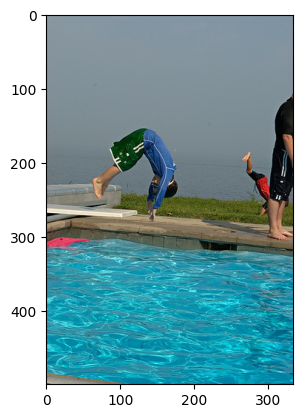

<start> a boy flips off a diving board into a pool  <end>
<start> a boy is diving off a diving board into a swimming pool  <end>
<start> a child is diving into a pool  <end>
<start> a child jumping into a swimming pool from the diving board  <end>
<start> child flips off pool diving board  man and another tumbling child at poolside  <end>


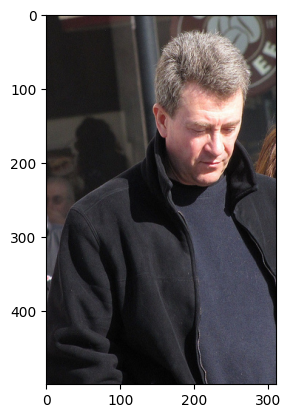

<start> a man in a black jacket is beside the window of a coffee shop looking down  <end>
<start> a man in a dark jacket looking down  <end>
<start> a man wearing a black jacket looking down  <end>
<start> a man wearing a black shirt and sweater is looking down  <end>
<start> an older man in a black jacket looking down  <end>


In [ ]:
# Show captions and Image
show_img_desc(df_cap)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer
# "OOV" stands for "Out-Of-Vocabulary," referring to words that are not present in the vocabulary or training data. Values of OVV = 'UNK' (unknown)
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')
tokenizer.index_docs

defaultdict(int, {})

In [ ]:
tokenizer.index_word

{}

In [ ]:
# Fit captions in df_cap to tokenizer and test values of text after fit text
tokenizer.fit_on_texts(df_cap['Captions'])

#transform each text into a sequence of integers
text_to_cvt = ['a wide river with many small waterfalls',
               'a sled dog pulling a blue toy excavator in the snow']
print(tokenizer.texts_to_sequences(text_to_cvt))

[[2, 679, 227, 11, 268, 53, 2559], [2, 375, 10, 392, 2, 31, 105, 1, 5, 6, 45]]


In [ ]:
train_seqs = tokenizer.texts_to_sequences(df_cap['Captions'])
train_seqs[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

# ## Note##
# - Start value =3 and end value = 4. This is ID of <start> and <end>
# - Let see in line below

In [ ]:
# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog'}

In [ ]:
# Crate PAD with index = 0
# In Tokenizer: Normalize the string length by adding PAD to equal the overall length of a sentence
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

tokenizer.index_word = dict(sorted(tokenizer.index_word.items()))

# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{0: 'PAD',
 1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and'}

In [ ]:
# Check created PAD
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [ ]:
# Create a word count of your tokenizer to visulize
# the Top 32 occuring words after text processing include <start> and <end>
tokenizer_top_words = [word for line in df_cap['Captions'] for word in line.split() ]

# Tokenizer_top_words_count
tokenizer_top_words_count = Counter(tokenizer_top_words)
tokenizer_top_words_count.most_common(32)

[('a', 62986),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

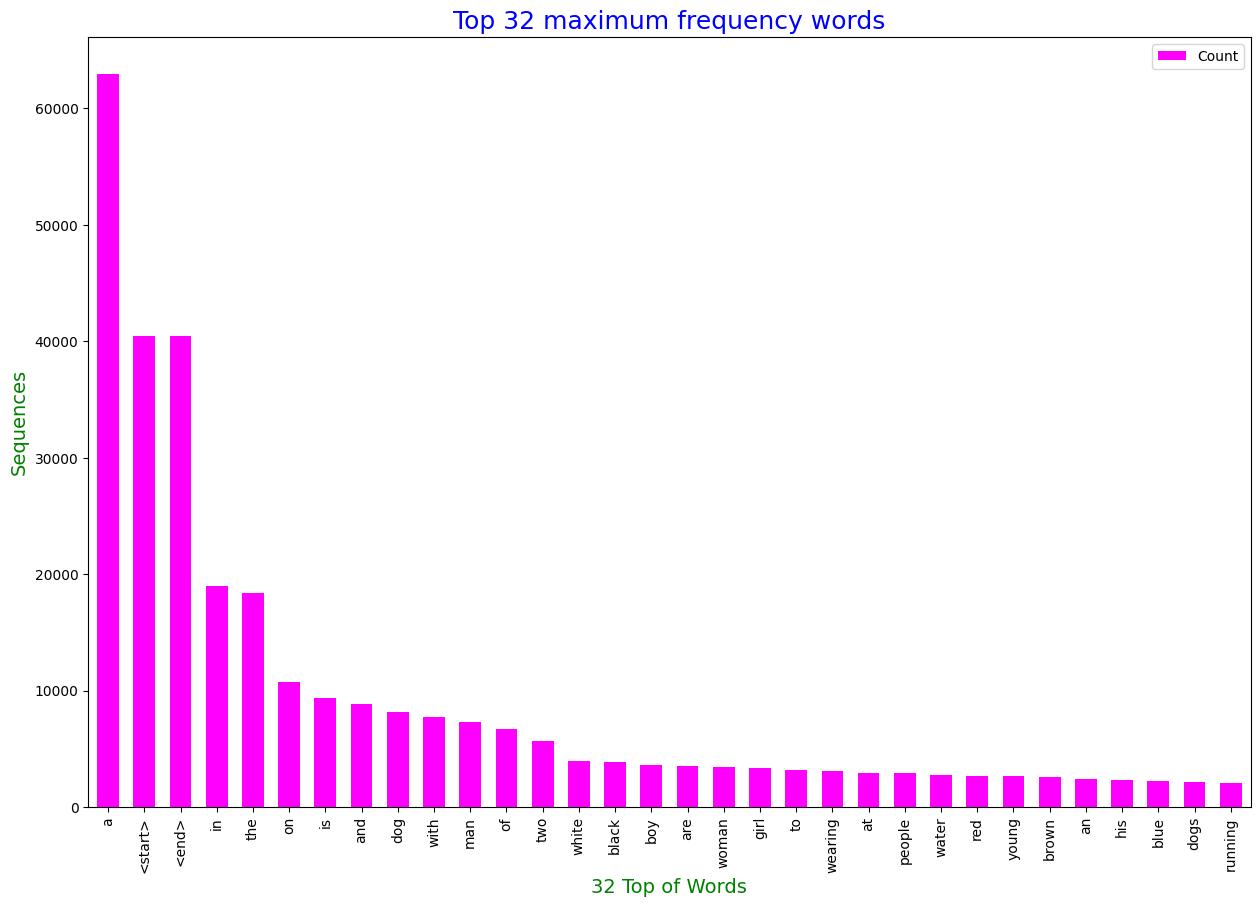

In [ ]:
most_top_word(tokenizer_top_words_count, ntop=32)

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]
longest_word_length = max(train_seqs_len)
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                          padding= 'post',
                                                          maxlen = longest_word_length,
                                                          dtype='int32',
                                                          value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 38)


In [ ]:
# Check caption, token and vector-caption
print(df_cap['Captions'][0])
print(train_seqs[0])
print(cap_vector[0])

<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4]
[  3   2  43   5   2  91 171   8 120  54   2 396  13 393   5  29   1 694
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


## Now, Pre-processing the images and Use Pretrain network 

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
# Load inceptionV3 with no softmax layer
# Create load_image to read image and image processing to the correct input standard of the InceptionV3 network
inception_model = InceptionV3(weights='imagenet', include_top=False)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = preprocess_input(image)
    image = tf.expand_dims(image, axis=0)
    return image, image_path

# Create function to extract features from load_image function with a BATCH
@tf.function
def get_image_features(images):
    features = tf.map_fn(lambda x: inception_model(x, training=False), images)
    return features

In [ ]:
# Test load_image function
img_path = '../data/Images/10815824_2997e03d76.jpg'
features_test, _ = load_image(img_path)
print(features_test.shape)

(1, 299, 299, 3)


In [ ]:
# Now, Get unique values in df_cap['Path']
# to compare the following features. because there are 5*8091 captions, 
# Can't load that much image will cause memory loss. 
# The solution is to load each image once and map it to an features based on the image name

img_proc_list = tf.data.Dataset.from_tensor_slices(df_cap['Path'].unique())
img_proc_list = img_proc_list.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)

img_proc_list = img_proc_list.batch(16, drop_remainder=False)
img_proc_list

<BatchDataset shapes: ((None, 1, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
# Test a batch
batchIMG, pathDir = next(iter(img_proc_list))
pathDir

<tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1001773457_577c3a7d70.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1002674143_1b742ab4b8.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1003163366_44323f5815.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1007129816_e794419615.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1007320043_627395c3d8.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1009434119_febe49276a.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1012212859_01547e3f17.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1015118661_980735411b.jpg',
       b'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1015584366_dfcec3c85a.

In [ ]:
feature_path = pathDir[0].numpy().decode('utf-8')
feature_path

'/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg'

In [ ]:
batchIMG[0]

<tf.Tensor: shape=(1, 299, 299, 3), dtype=float32, numpy=
array([[[[-5.4579198e-01, -5.1085913e-01, -3.7435186e-01],
         [-1.4921635e-01, -1.9675493e-04, -3.1106710e-02],
         [-9.7177267e-02,  4.6858430e-02,  4.3021560e-02],
         ...,
         [-9.7224247e-01, -9.6819955e-01, -9.8191810e-01],
         [-9.6078575e-01, -9.4020623e-01, -9.7377020e-01],
         [-9.6212077e-01, -9.3846858e-01, -9.8195148e-01]],

        [[-5.7653260e-01, -5.3617233e-01, -4.2858374e-01],
         [-1.4806336e-01,  5.8089495e-03, -5.5708170e-02],
         [-7.8158259e-02,  6.0893416e-02,  7.8846335e-02],
         ...,
         [-9.6420521e-01, -9.5636207e-01, -9.8523390e-01],
         [-9.3927324e-01, -9.2645574e-01, -9.5595336e-01],
         [-9.9189347e-01, -9.6899247e-01, -9.7989315e-01]],

        [[-5.9273523e-01, -5.6866682e-01, -4.3528360e-01],
         [-1.3315433e-01,  5.4714680e-03, -1.3691187e-02],
         [-8.0161095e-02,  5.6944609e-02,  1.0495746e-01],
         ...,
         [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize :  (1, 299, 299, 3)
Shape after resize :  (1, 299, 299, 3)
Shape after resize :  (1, 299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize :  (1, 299, 299, 3)
Shape after resize :  (1, 299, 299, 3)


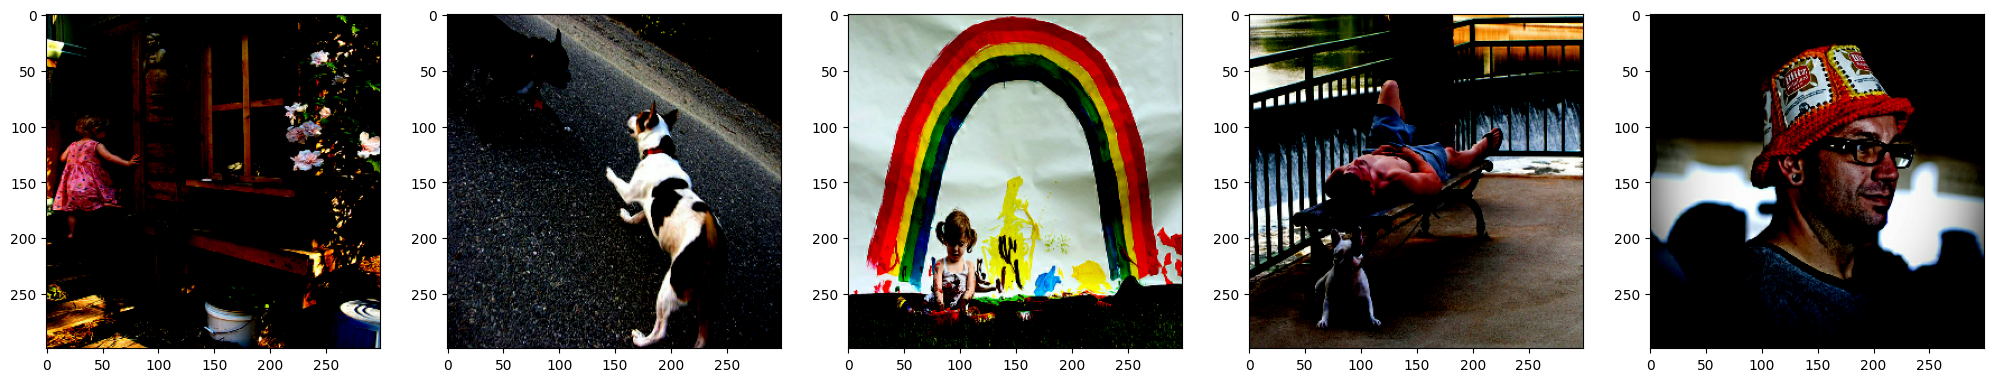

In [ ]:
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)

for ax, image in zip(axes, batchIMG[0:6]) :
    print('Shape after resize : ', image.shape)
    ax.imshow(image[0])

In [ ]:
# Create train-test based on Path and Caption-vector has created before
path_train, path_test, cap_train, cap_test = train_test_split(df_cap['Path'].to_numpy(),
                                                              cap_vector,
                                                              test_size=0.2,
                                                              random_state=101)

In [ ]:
path_test.shape, path_test[0]

((8091,),
 '/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/3025513877_1a6160070d.jpg')

In [ ]:
cap_test.shape, cap_test[0]

((8091, 38),
 array([   3,    6,   17,    5,    6,   26,   96,    9,   38,    8,  656,
           5,    6, 3299,   13,    6,  227,    4,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=int32))

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# After Create all of Unique image from Path, I get features each of image processing
img_features = {}
progress_bar = tqdm(img_proc_list, dynamic_ncols=True)
for idx, (image, image_path) in enumerate(progress_bar):
    batch_features = get_image_features(image)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[-1]))
    progress_bar.set_description(f"Processing item: {idx}")
                                     
    for batch_feat, path in zip(batch_features, image_path) :
        feature_path = path.numpy().decode('utf-8')
        img_features[feature_path] = batch_feat

  0%|                                                   | 0/506 [00:00<?, ?it/s]2023-05-24 22:39:01.002223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-05-24 22:39:01.440359: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-24 22:39:01.441158: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-24 22:39:01.441168: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-05-24 22:39:01.441203: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform p

In [ ]:
len(img_features)

8091

In [ ]:
batch_features.shape

TensorShape([11, 64, 2048])

In [ ]:
# Show Image Features
for i in list(img_features.keys())[:2]:
    print(i)
    print(img_features[i])
    print('=========')

/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1000268201_693b08cb0e.jpg
tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.16990492]
 [0.         0.         1.0107268  ... 0.         0.         0.06127125]
 ...
 [0.         0.         2.0364974  ... 1.202505   0.         1.992039  ]
 [0.         0.         0.904861   ... 0.         0.         0.        ]
 [0.         1.2533348  0.         ... 0.         0.         0.        ]], shape=(64, 2048), dtype=float32)
/home/xavier/Documents/LJMU/Eye_for_blind_Root/data/Images/1001773457_577c3a7d70.jpg
tf.Tensor(
[[0.         0.6636172  0.46282685 ... 0.         0.         3.3328762 ]
 [0.         1.2267039  0.         ... 0.         0.25395167 3.3293803 ]
 [1.2879006  1.5197086  0.         ... 0.46730775 0.36473367 3.817177  ]
 ...
 [0.33696595 2.8775475  0.         ... 0.         1.0877295  0.        ]
 [0.20812286 1.0365759  0.       

In [ ]:
# As previous instructions, the function below will perform feature mapping based on the image path
def image_feature_map(imagePath, caption):
    try:
        feature_tensor = img_features[imagePath.decode('utf-8')]
    except:
        feature_tensor = img_features[imagePath]
    return feature_tensor, caption

In [ ]:
# Check if the data has not been tampered
imagePath = df_cap['Path'][100]
caption_test = df_cap['Captions'][100]

In [ ]:
print(image_feature_map(imagePath, caption_test))

(<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.7456657 , 0.        , ..., 0.4648503 , 1.4360653 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.55025905, 0.9472825 ,
        0.        ],
       [0.        , 0.        , 0.43363747, ..., 1.3019289 , 0.5834913 ,
        0.        ],
       ...,
       [1.2096509 , 2.3545842 , 0.        , ..., 0.6384333 , 1.1969461 ,
        1.7225298 ],
       [0.99858814, 1.2055167 , 0.        , ..., 0.        , 0.6624175 ,
        1.683619  ],
       [0.509127  , 1.373202  , 0.5687549 , ..., 0.        , 0.71535736,
        1.3767656 ]], dtype=float32)>, '<start> two different breeds of brown and white dogs play on the beach  <end>')


In [ ]:

get = inception_model(load_image(imagePath)[0], training=False)
get = tf.reshape(get, (get.shape[0], -1, batch_features.shape[-1]))
get[0]

2023-05-24 22:40:49.045033: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.7443793 , 0.        , ..., 0.46211293, 1.4344803 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.54818636, 0.94645983,
        0.        ],
       [0.        , 0.        , 0.43218535, ..., 1.3003956 , 0.58290493,
        0.        ],
       ...,
       [1.2110466 , 2.3529522 , 0.        , ..., 0.6388612 , 1.1964794 ,
        1.7242053 ],
       [0.99821645, 1.202174  , 0.        , ..., 0.        , 0.6627684 ,
        1.6841851 ],
       [0.50756353, 1.3732092 , 0.56865096, ..., 0.        , 0.7152756 ,
        1.3772913 ]], dtype=float32)>

- Mapping was successful

In [ ]:
# With train-test created before, defined gen_dataset function to mapping all captions with features
BUFFER_SIZE = 1000
BATCH_SIZE = 64

def gen_dataset(img, capt):
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    
    data = data.map(lambda val1, val2 : tf.numpy_function(image_feature_map, [val1, val2], [tf.float32, tf.int32]))
    data = data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    data = data.batch(BATCH_SIZE, drop_remainder=False)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [ ]:
train_dataset = gen_dataset(path_train, cap_train)
test_dataset = gen_dataset(path_test, cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 38)


In [ ]:
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
print("Train dataset size:", train_dataset_size, f"(~= {path_train.shape[0]/BATCH_SIZE})")

test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()
print("Test dataset size:", test_dataset_size, f"(~= {path_test.shape[0]/BATCH_SIZE})")

Train dataset size: 506 (~= 505.6875)
Test dataset size: 127 (~= 126.421875)


In [ ]:
# GPU acceleration: TensorFlow's @tf.function can automatically optimize code for GPU execution.
# By converting your code to a graph representation,
# TensorFlow can efficiently utilize GPU resources,
# leading to faster computations on GPU devices.
# @tf.function use as a decorator for the functions below

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

### Encoder

In [ ]:
embedding_dim = 256 
units = 512

vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length = longest_word_length
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [ ]:
class Encoder(Model):
    '''
    Reduced 2048 dimension features from output of InceptionV3 to 256
    The output is 1 relu activation function
    '''
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features =  self.dense(features)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

### Attention model

In [ ]:
class Attention_model(Model):
    '''
    The network takes two inputs, the features vector and the states of the decoder hidden sdtate.
    The output of Attention is Context Vector
    
    '''
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # These scores represent the relevance or importance 
        # of each element with respect to the current decoder hidden state
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "eye_blind/ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_op = encoder(img_tensor)

        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
            #pass encoder_op to decoder
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions) 
            dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)

    #apply teacher forcing again
        for r in range(1, target.shape[1]) :
        #pass encoder_op to decoder
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions)

            dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))                      


    return loss, avg_loss


In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    test_num_steps = len(test_dataset)

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss


In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10

loss_create_val=100
epoch_process = tqdm(range(EPOCHS), dynamic_ncols=True)
for epoch, _ in enumerate(epoch_process):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < loss_create_val:
        print('Test loss has been reduced from %.3f to %.3f' % (loss_create_val, test_loss))
        loss_create_val = test_loss
        ckpt_manager.save()

 10%|████▎                                      | 1/10 [02:13<20:04, 133.83s/it]

For epoch: 1, the train loss is 1.296, & test loss is 1.063
Time taken for 1 epoch 133.74299144744873 sec

Test loss has been reduced from 100.000 to 1.063


 20%|████████▊                                   | 2/10 [03:12<11:56, 89.50s/it]

For epoch: 2, the train loss is 0.993, & test loss is 0.937
Time taken for 1 epoch 58.38692879676819 sec

Test loss has been reduced from 1.063 to 0.937


 30%|█████████████▏                              | 3/10 [04:10<08:46, 75.26s/it]

For epoch: 3, the train loss is 0.899, & test loss is 0.861
Time taken for 1 epoch 58.22008037567139 sec

Test loss has been reduced from 0.937 to 0.861


 40%|█████████████████▌                          | 4/10 [05:09<06:51, 68.60s/it]

For epoch: 4, the train loss is 0.835, & test loss is 0.803
Time taken for 1 epoch 58.308082818984985 sec

Test loss has been reduced from 0.861 to 0.803


 50%|██████████████████████                      | 5/10 [06:07<05:24, 64.89s/it]

For epoch: 5, the train loss is 0.782, & test loss is 0.753
Time taken for 1 epoch 58.22209811210632 sec

Test loss has been reduced from 0.803 to 0.753


 60%|██████████████████████████▍                 | 6/10 [07:05<04:10, 62.68s/it]

For epoch: 6, the train loss is 0.736, & test loss is 0.709
Time taken for 1 epoch 58.29801368713379 sec

Test loss has been reduced from 0.753 to 0.709


 70%|██████████████████████████████▊             | 7/10 [08:04<03:03, 61.30s/it]

For epoch: 7, the train loss is 0.695, & test loss is 0.670
Time taken for 1 epoch 58.354368925094604 sec

Test loss has been reduced from 0.709 to 0.670


 80%|███████████████████████████████████▏        | 8/10 [09:03<02:01, 60.54s/it]

For epoch: 8, the train loss is 0.656, & test loss is 0.633
Time taken for 1 epoch 58.820955991744995 sec

Test loss has been reduced from 0.670 to 0.633


 90%|███████████████████████████████████████▌    | 9/10 [10:03<01:00, 60.36s/it]

For epoch: 9, the train loss is 0.621, & test loss is 0.599
Time taken for 1 epoch 59.881630182266235 sec

Test loss has been reduced from 0.633 to 0.599


100%|███████████████████████████████████████████| 10/10 [11:04<00:00, 66.41s/it]

For epoch: 10, the train loss is 0.589, & test loss is 0.567
Time taken for 1 epoch 60.9553108215332 sec

Test loss has been reduced from 0.599 to 0.567


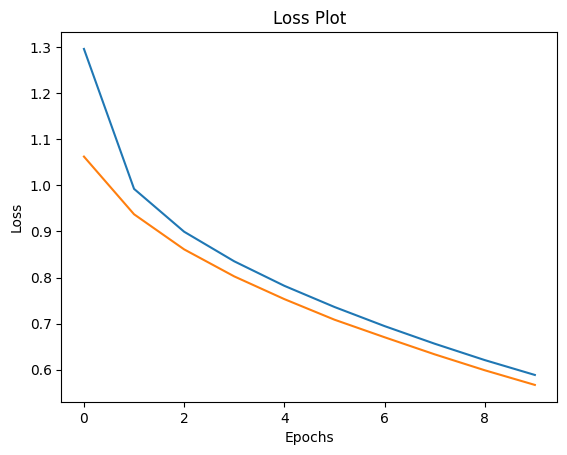

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)
    temp_input = load_image(image)[0] #tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = get_image_features(tf.expand_dims(temp_input, 0))
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[-1]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        word = tokenizer.index_word[predicted_id]
        result.append(word)

        if word == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize = (10, 10))
    temp_img = np.array(Image.open(image))

    cap_len = len(caption)
    for cap in range(cap_len) :
        weights_img = np.reshape(weights[cap], (8,8))
        wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.Resampling.LANCZOS))

        ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
        ax.set_title(caption[cap], fontsize = 14, color = 'red')

        img = ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def speech_text(text):
    # Speech text with Google Text to Speech API
    sound_obj = gTTS(text=text, lang='en', slow=False)
    sound_obj.save("sample.mp3")
    os.system("mpg321 sample.mp3")

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 22.960711579379538

Real Caption:
 A boy and girl are splashing around in the ocean
Prediction Caption:
 Two boys playing in the ocean


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from sample.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:02] Decoding of sample.mp3 finished.


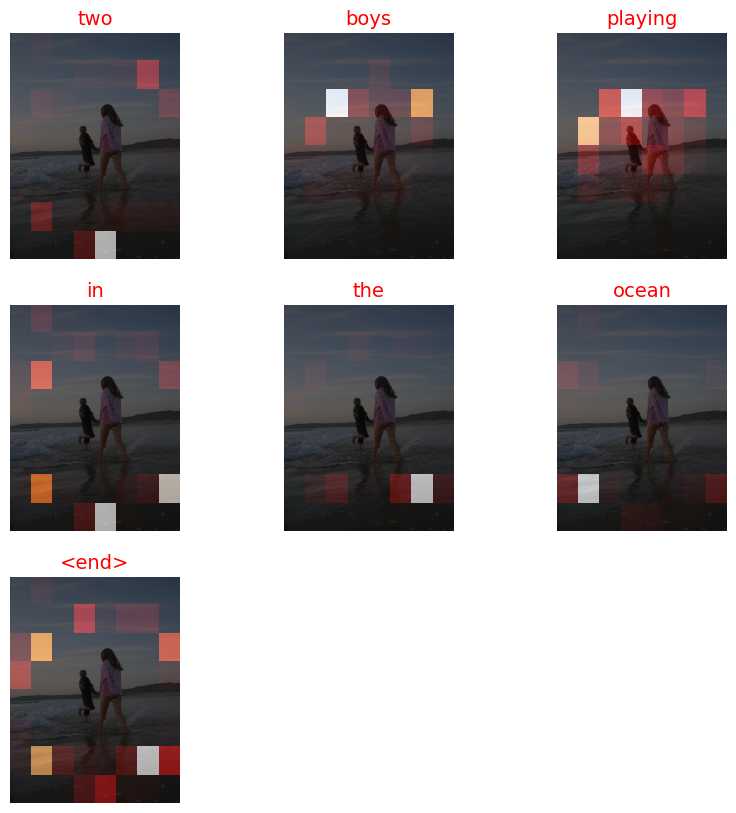

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}\n")

print ('Real Caption:\n', real_caption.capitalize())
print ('Prediction Caption:\n', pred_caption.capitalize())
plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

speech_text(pred_caption)

In [ ]:
def predict_and_speech(img):
    result, attention_plot, pred_test = evaluate(img)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    print(f"BELU score: {score*100}\n")
    print ('Prediction Caption:\n', pred_caption.capitalize())
    speech_text(pred_caption)
    plot_attmap(result, attention_plot, img)

In [ ]:
img_list = glob.glob('img_test/*.*')

BELU score: 7.165741990418252e-153

Prediction Caption:
 A girl in a black swimsuit is holding a black swimsuit is smiling


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from sample.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:04] Decoding of sample.mp3 finished.


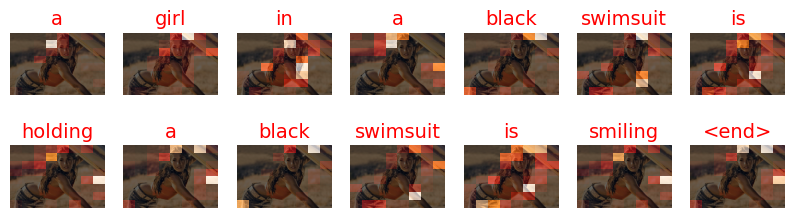

In [ ]:
predict_and_speech(img_list[0])

BELU score: 4.421625271317475e-153

Prediction Caption:
 A creek puddle in a stream


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from sample.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:02] Decoding of sample.mp3 finished.


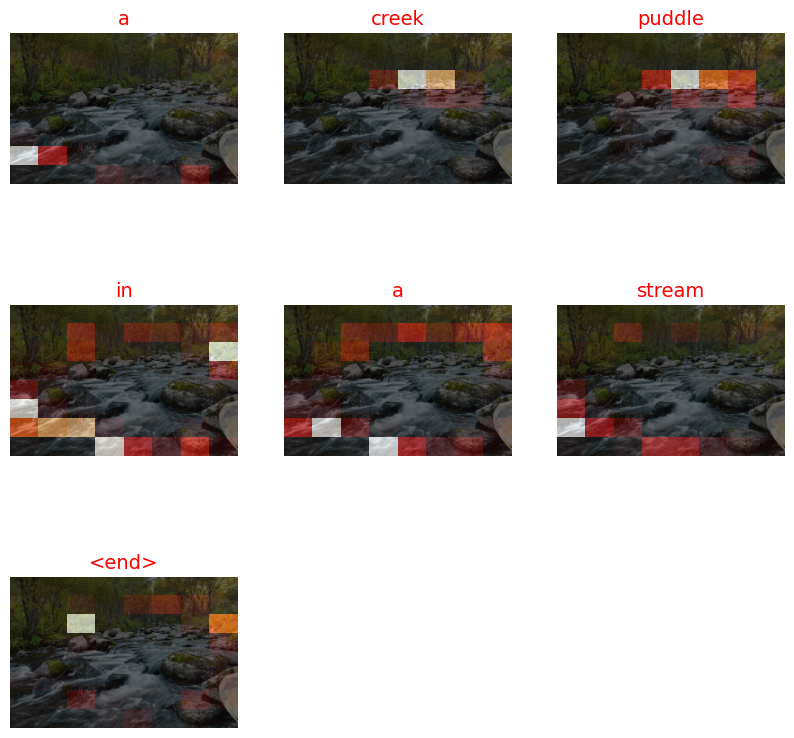

In [ ]:
predict_and_speech(img_list[2])

BELU score: 6.360494346864464e-153

Prediction Caption:
 A man in a yellow hat is holding a red collar


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from sample.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:03] Decoding of sample.mp3 finished.


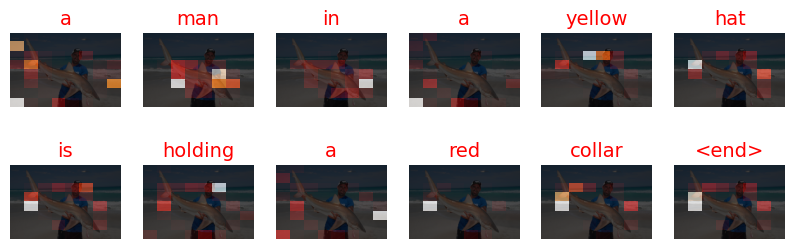

In [ ]:
predict_and_speech(img_list[3])

BELU score: 6.360494346864464e-153

Prediction Caption:
 A man in a blue shirt is running with a ball


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from sample.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:02] Decoding of sample.mp3 finished.


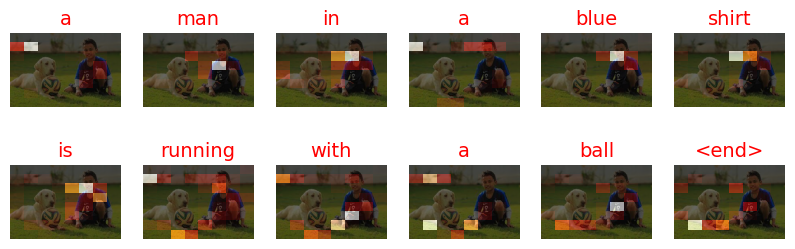

In [ ]:
predict_and_speech(img_list[4])